In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter

In [2]:
os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf

In [3]:
import glob

path = r'H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues'
extension = 'csv'
os.chdir(path)
filenames = glob.glob('*.{}'.format(extension))
print(filenames)

['cov2para_evs_df.csv', 'cov2para_fixed04_evs_df.csv', 'cov2para_plus02_evs_df.csv', 'qis_evs_df.csv', 'qis_evs_df_p100.csv', 'qis_evs_df_p225.csv', 'qis_evs_df_p30.csv', 'qis_evs_df_p50.csv', 'qis_evs_df_p500.csv', 'qis_evs_exp_05.csv', 'qis_evs_exp_2.csv', 'sample_evs_df.csv', 'sample_evs_df_p100.csv', 'sample_evs_df_p225.csv', 'sample_evs_df_p30.csv', 'sample_evs_df_p50.csv', 'sample_evs_df_p500.csv']


In [4]:
def get_ev_intensities(evs, sample_evs):
    intensities = evs.copy()
    intensities.iloc[:, -251:] = evs.iloc[:, -251:].values / sample_evs.iloc[:, -251:].values
    return intensities

def plot_last_x_intensities_across_time(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Time",
         labels={'value':f'Mean of EV(Model) / EV(Sample)'},
        height=700
    )
    fig.show()

def plot_last_x_intensities_across_assets(intensities_dfs, modelnames, num_evs, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [intensities_dfs[M].iloc[:, -num_evs:].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = intensities_dfs[modelnames[0]].iloc[:, -num_evs:].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) / EV(Sample) Across Assets",
         labels={'value':f'Mean of EV(Model) / EV(Sample)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def plot_last_x_eigenvalues_across_time(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1) for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean(axis=1)
        df.name = modelnames[0]
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Time",
         labels={'value':f'Mean of EV(Model) '},
        height=700
    )
    fig.show()

def plot_last_x_eigenvalues_across_assets(eigenvalues_dfs, modelnames, ev_range, return_df=False):
    if len(modelnames) > 1:
        dfs_list = [eigenvalues_dfs[M].iloc[:, ev_range[0]:ev_range[1]].mean() for M in modelnames]
        df = pd.concat(dfs_list, axis=1)
        df.columns = modelnames
    else:
        df = eigenvalues_dfs[modelnames[0]].iloc[:, ev_range[0]:ev_range[1]].mean()
        df.name = modelnames[0]
        
    fig = px.line(
        df,
        title = f"Plot of Average EV(Model) Across Assets",
         labels={'value':f'Mean of EV(Model)', 'index': "Eigenvalue"},
        height=700
    )
    fig.show()


def get_rawres(eigenvalue_dict, modelnames: list):
    tmp_res = defaultdict(list)
    tmp_rawres = defaultdict(list)
    for idx in range(0, permnos.shape[0]):
        try:
            past_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx - 21 * 12 * 1: idx + add_idx, :]
            past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
            past_ret_mat = past_ret_mat.fillna(0)
            fut_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx: idx + add_idx + 21, :]
        except:
            print("Some Error..")
            
        N, p = past_ret_mat.shape
        sample = pd.DataFrame(np.matmul(past_ret_mat.T.to_numpy(), past_ret_mat.to_numpy())) / (N - 1)
        lambda1, u = np.linalg.eigh(sample)
        lambda1 = lambda1.real.clip(min=0)
        dfu = pd.DataFrame(u,columns=lambda1)
        dfu.sort_index(axis=1,inplace = True)
        temp1 = dfu.to_numpy()
        temp3 = dfu.T.to_numpy().conjugate()

        for cur_modelname in modelnames:
            qis = eigenvalue_dict[cur_modelname].iloc[idx, :]
            temp2 = np.diag(qis)
            sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1, temp2), temp3))
            try:
                weights = hf.calc_global_min_variance_pf(sigmahat)
            except:
                print("Some Other Error..")
            # store results
            tmp_res[cur_modelname].append(np.std(fut_ret_mat @ weights, ddof=1) * np.sqrt(252) * 100)
            if idx % 21 == 0:
                tmp_rawres[cur_modelname] += list(fut_ret_mat @ weights)

    return tmp_rawres, tmp_res
    

### Load data and calculate Intensities

In [5]:
model_names = ["cov2para", "cov2para_plus02", "cov2para_fixed04", "qis", "qis_exp05", "qis_exp2", "sample"]

In [6]:
evs_dfs = {}
evs_dfs["cov2para"] =  pd.read_csv('cov2para_evs_df.csv', index_col=0)
evs_dfs["cov2para_plus02"] =  pd.read_csv('cov2para_plus02_evs_df.csv', index_col=0)
evs_dfs["cov2para_fixed04"] =  pd.read_csv('cov2para_fixed04_evs_df.csv', index_col=0)
evs_dfs["qis"] = pd.read_csv('qis_evs_df.csv', index_col=0)
evs_dfs["qis_exp05"] = pd.read_csv('qis_evs_exp_05.csv')
evs_dfs["qis_exp2"] = pd.read_csv('qis_evs_exp_2.csv')
evs_dfs["sample"] = pd.read_csv('sample_evs_df.csv', index_col=0)

In [7]:
base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
pf_size = 500
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")

In [8]:
intensities_dfs = {}
for k, v in evs_dfs.items():
    v.index = pd.to_datetime(permnos.index, format="%Y%m%d")
    intensities_dfs[k] = get_ev_intensities(v, evs_dfs["sample"])

## define additional weightings

In [ ]:
def sigmoid(x):
    return 2* ( 1 / (1+np.exp(-x)) )
w_05_20 = [sigmoid(i/100) for i in range(-100,400,1)]
w_20_05 = w_05_20[::-1]

In [ ]:
w_f1 = [sigmoid(i/100) for i in np.linspace(-100, -75, 249)]
w_f2 = [sigmoid(i/100) for i in np.linspace(-75, 400, 251)]
w_custom = w_f1+w_f2
w_custom_inverse = [1/i for i in w_custom]


In [ ]:
model_names.append("qis_05_20")
evs_dfs["qis_05_20"] = evs_dfs["qis"] * w_05_20
intensities_dfs["qis_05_20"] = get_ev_intensities(evs_dfs["qis_05_20"], evs_dfs["sample"])

model_names.append("qis_20_05")
evs_dfs["qis_20_05"] = evs_dfs["qis"] * w_20_05
intensities_dfs["qis_20_05"] = get_ev_intensities(evs_dfs["qis_20_05"], evs_dfs["sample"])

model_names.append("qis_custom")
evs_dfs["qis_custom"] = evs_dfs["qis"] * w_custom
intensities_dfs["qis_custom"] = get_ev_intensities(evs_dfs["qis_custom"], evs_dfs["sample"])

model_names.append("qis_custom_inverse")
evs_dfs["qis_custom_inverse"] = evs_dfs["qis"] * w_custom_inverse
intensities_dfs["qis_custom_inverse"] = get_ev_intensities(evs_dfs["qis_custom_inverse"], evs_dfs["sample"])

In [ ]:
model_names

In [ ]:
plot_last_x_intensities_across_time(intensities_dfs, 
                                    ["qis", "cov2para", "qis_exp05", "qis_exp2", 'cov2para_plus02', "cov2para_fixed04",
                                     "qis_05_20", "qis_20_05", "qis_custom", "qis_custom_inverse"],
                                    251)

In [ ]:
plot_last_x_intensities_across_assets(intensities_dfs, 
                                    ["qis", "cov2para", "qis_exp05", "qis_exp2", 'cov2para_plus02', "cov2para_fixed04",
                                     "qis_05_20", "qis_20_05", "qis_custom", "qis_custom_inverse"],
                                    251)

In [ ]:
plot_last_x_intensities_across_assets(intensities_dfs, 
                                    ["qis", "cov2para", "qis_exp05", "qis_exp2", 'cov2para_plus02', "cov2para_fixed04",
                                     "qis_05_20", "qis_20_05", "qis_custom", "qis_custom_inverse"],
                                    251)

In [ ]:
x1 = intensities_dfs["cov2para"]

### Test Clustering of eigenvalues or Eigenvalue Intensities

In [ ]:
from sklearn.cluster import DBSCAN, KMeans



In [ ]:
clustering = DBSCAN().fit(evs_dfs['qis'])

In [ ]:
kmeans = KMeans().fit(evs_dfs['qis'].T)

In [ ]:
Counter(kmeans.labels_)

In [ ]:
kmeans.labels_

In [ ]:
Counter(clustering.labels_)

### Evaluating new transformed QIS eigenvalues

In [9]:
import pickle

base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = 500
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [10]:
for num_ev in [1]:
    tmp_res = defaultdict(list)
    tmp_rawres = defaultdict(list)
    for idx in range(0, permnos.shape[0]):
        try:
            past_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx - 21 * 12 * 1: idx + add_idx, :]
            past_ret_mat = past_ret_mat.sub(past_ret_mat.mean())
            past_ret_mat = past_ret_mat.fillna(0)
            fut_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx: idx + add_idx + 21, :]
        except:
            print("Some Error..")
        N, p = past_ret_mat.shape
        sample = pd.DataFrame(np.matmul(past_ret_mat.T.to_numpy(), past_ret_mat.to_numpy())) / (N - 1)
        lambda1, u = np.linalg.eigh(sample)
        lambda1 = lambda1.real.clip(min=0)
        dfu = pd.DataFrame(u,columns=lambda1)
        dfu.sort_index(axis=1,inplace = True)
        temp1 = dfu.to_numpy()
        temp3 = dfu.T.to_numpy().conjugate()

        for cur_modelname in ['qis', 'qis_custom', 'qis_custom_inverse', 'qis_05_20', 'qis_20_05']:
            qis = evs_dfs[cur_modelname].iloc[idx, :]
            temp2 = np.diag(qis)
            sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1, temp2), temp3))
            try:
                weights = hf.calc_global_min_variance_pf(sigmahat)
            except:
                print("Some Other Error..")
            # store results
            tmp_res[cur_modelname].append(np.std(fut_ret_mat @ weights, ddof=1) * np.sqrt(252) * 100)
            if idx % 21 == 0:
                tmp_rawres[cur_modelname] += list(fut_ret_mat @ weights)
    
    #all_res[cur_modelname] = tmp_res
    #all_rawres[cur_modelname] = tmp_rawres

KeyError: 'qis_custom'

In [ ]:
for k, v in tmp_rawres.items():
    print(f"{k}: ", np.std(v[5040:]) * np.sqrt(252) * 100)


## Combine CVC and QIS via convex combination of their eigenvalues?

In [ ]:
evs_dfs['70cov2para_30qis'] = evs_dfs['cov2para'] * 0.3 + 0.7 * evs_dfs['qis']
intensities_dfs["70cov2para_30qis"] = get_ev_intensities(evs_dfs["70cov2para_30qis"], evs_dfs["sample"])
rawres, temp_res = get_rawres(evs_dfs, ['70cov2para_30qis'])

In [ ]:
plot_last_x_intensities_across_assets(intensities_dfs, 
                                    ["qis", "cov2para", "70cov2para_30qis"],
                                    251)

In [ ]:
np.std(rawres['70cov2para_30qis'][5040:]) * np.sqrt(252) * 100

### Neue Idee: Eine Faktor auf dem QIS/SAMPLE Eigenwert-Quotient. 

Now let's try out the new idea: the intensity (lambda_qis / lambda_sample) and subtract 1 from it (because 1 would be lambda_qis = lambda_sample).
Then on this we apply our alpha ("intensity of intensity?") and then recalculate our new qis eigenvalues

- auch nicht ganz sauber, da eigentlich die ersten 249 intensities auch nicht wirklich dasselbe sind wie die restlichen 251 (da die ersten 249 sample eigenvalues 0 sind.)

Ganz einfach gesagt, macht diese Methode (zumindest für die grössten 251 eigenvalues// die non-null eigenvalues), dass die neuen QIS eigenvalues entweder **näher** (bei intensity of intensity unter 1) an den sample eigenvalues sind oder **weiter weg** (bei intensity of intensity > 1). Es ist auch eine intensity of intensity von 1 möglich, wo die neuen qis eigenwerte den alten qis eigenwerten entsprechen.
QIS Eigenwerte, die weiter weg sind von ihren zugehörigen Sample Eigenwerten, werden bei dieser Methode stärker verändert.

In [11]:
def get_new_eigenvalues(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    qis_evs_new.iloc[: , 0:250] = intensity_new.iloc[:, 0:250] * qis_eigenvalues.iloc[: , 0:250]
    return qis_evs_new

In [12]:
def get_new_eigenvalues_v2(qis_eigenvalues, sample_eigenvalues, intensity_of_intensity):
    intensity = qis_eigenvalues.copy()
    intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
    intensity_delta = intensity - 1
    intensity_delta_new = intensity_delta * intensity_of_intensity
    intensity_new = intensity_delta_new + 1
    qis_evs_new = intensity_new * sample_eigenvalues
    qis_evs_new.iloc[: , 0:250] = intensity_of_intensity * qis_eigenvalues.iloc[: , 0:250]
    return qis_evs_new

In [13]:
intensity_of_intensity = 1
qis_eigenvalues = evs_dfs["qis"]
sample_eigenvalues = evs_dfs["sample"]

intensity = qis_eigenvalues.copy()
intensity.iloc[: , -251:] = qis_eigenvalues.iloc[: , -251:] / sample_eigenvalues.iloc[: , -251:]
intensity_delta = intensity - 1
intensity_delta_new = intensity_delta * intensity_of_intensity
intensity_new = intensity_delta_new + 1
qis_evs_new = intensity_new * sample_eigenvalues
qis_evs_new.iloc[: , 0:250] = intensity_new.iloc[:, 0:250] * qis_eigenvalues.iloc[: , 0:250]

In [46]:
qis_evs_new = {}
intensities_new = {}
for intensity_of_intensity in [0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 2, 200]:
    qis_evs_new[intensity_of_intensity] = get_new_eigenvalues_v2(evs_dfs["qis"], evs_dfs["sample"], intensity_of_intensity)
    intensity = qis_evs_new[intensity_of_intensity].copy()
    intensity.iloc[: , -251:] = qis_evs_new[intensity_of_intensity].iloc[: , -251:] / evs_dfs["sample"].iloc[: , -251:]
    intensities_new[intensity_of_intensity] = intensity.copy()

In [15]:
if 1 == 2:
    plot_last_x_intensities_across_time(intensities_new,
                                    [0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
                                    251
                                   )

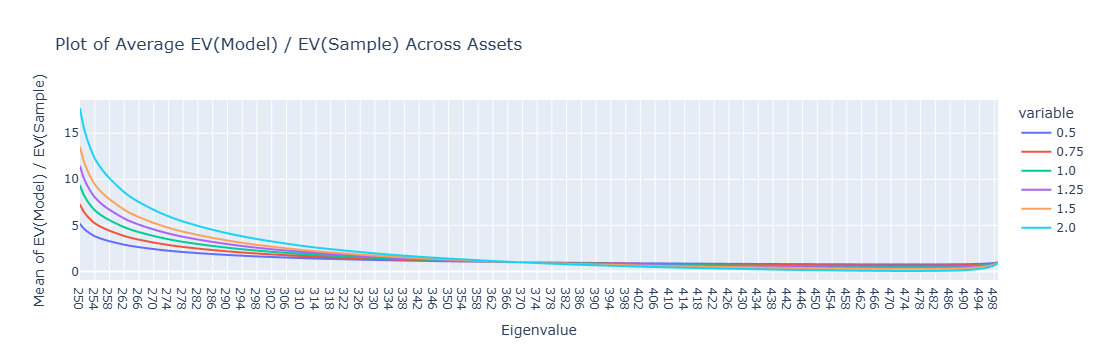

In [75]:
if 1 == 1:
    plot_last_x_intensities_across_assets(intensities_new,
                                        [0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
                                        250
                                         )

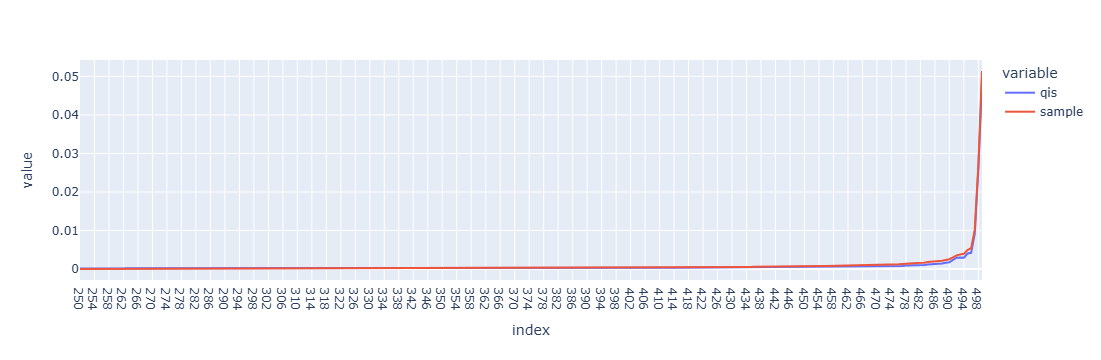

In [25]:
x = pd.concat((qis_eigenvalues.iloc[-1, 250:], sample_eigenvalues.iloc[-1, 250:]), axis=1)
x.columns = ["qis", "sample"]
px.line( x )

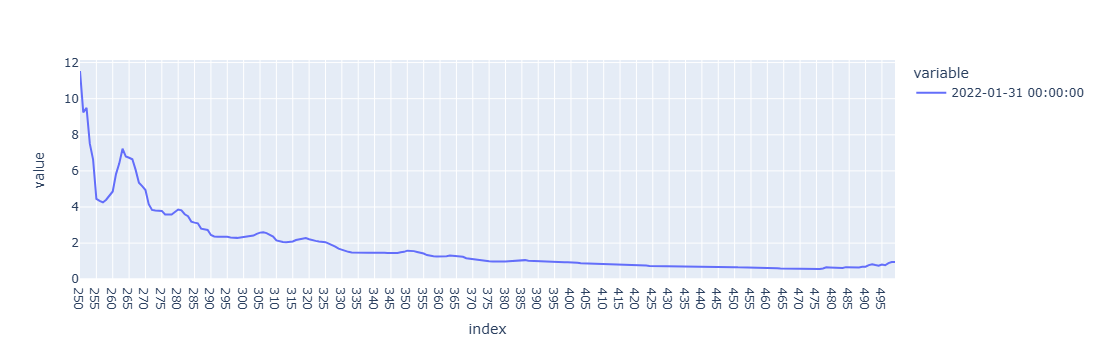

In [26]:
x = (qis_eigenvalues.iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
px.line( x )

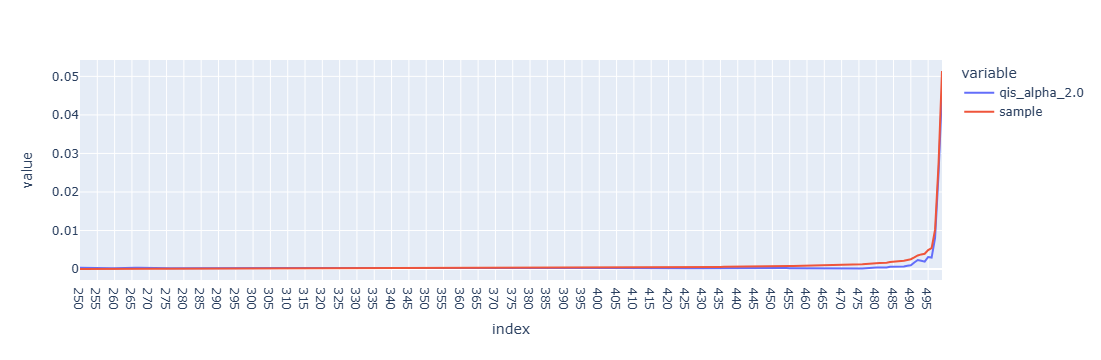

In [29]:
x = pd.concat((qis_evs_new[2.0].iloc[-1, 250:], sample_eigenvalues.iloc[-1, 250:]), axis=1)
x.columns = ["qis_alpha_2.0", "sample"]
px.line( x )

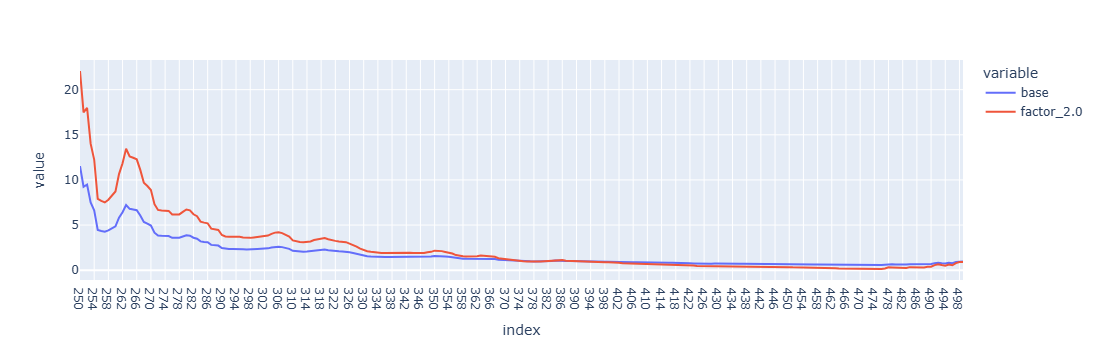

In [37]:
qis_sample_fac2 = (qis_evs_new[2.0].iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
qis_sample_base = (qis_eigenvalues.iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
x = pd.concat((qis_sample_base, qis_sample_fac2), axis=1)
x.columns = ["base", "factor_2.0"]
px.line( x )

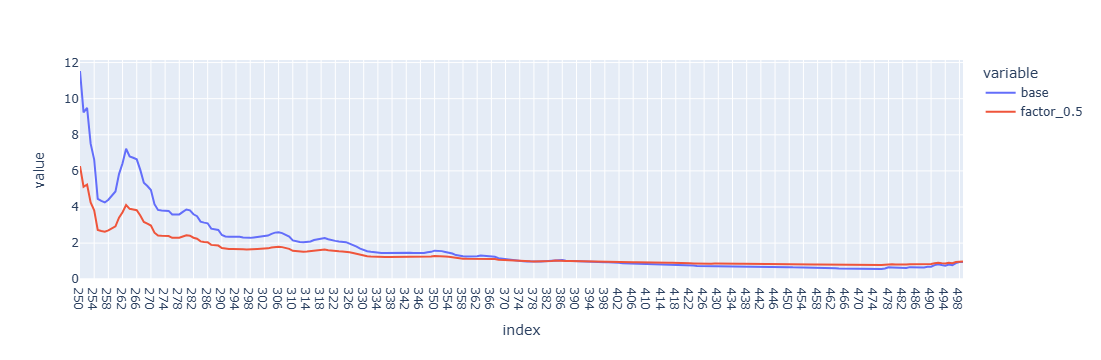

In [43]:
qis_sample_fac = (qis_evs_new[0.5].iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
qis_sample_base = (qis_eigenvalues.iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
x = pd.concat((qis_sample_base, qis_sample_fac), axis=1)
x.columns = ["base", "factor_0.5"]
px.line( x )

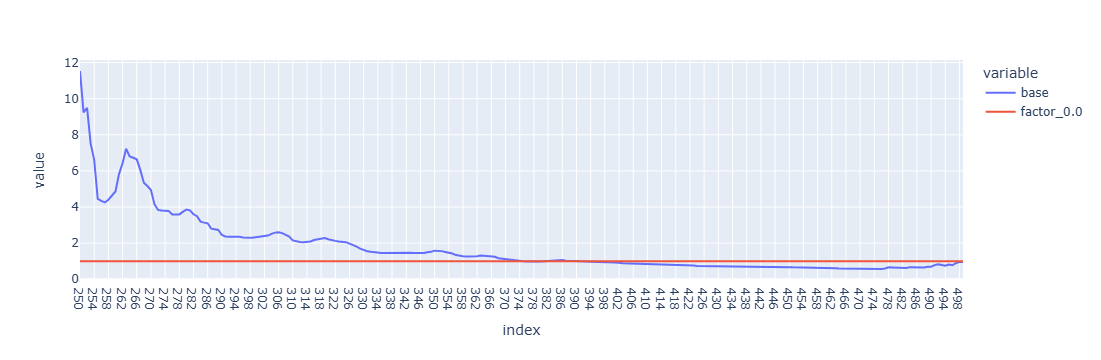

In [48]:
qis_sample_fac = (qis_evs_new[0].iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
qis_sample_base = (qis_eigenvalues.iloc[-1, 250:]/sample_eigenvalues.iloc[-1, 250:])
x = pd.concat((qis_sample_base, qis_sample_fac), axis=1)
x.columns = ["base", "factor_0.0"]
px.line( x )

In [35]:
x = pd.concat((qis_sample_base, qis_sample_fac2), axis=1)
x.columns = ["base", "factor_2.0"]

In [68]:
qis_evs_new[2.0].iloc[-1, -3:]

#qis_evs_new[2.0].iloc[-1, 250:253]

497    0.008076
498    0.024736
499    0.046259
Name: 2022-01-31 00:00:00, dtype: float64

In [69]:
evs_dfs["qis"].iloc[-1, -3:]

#evs_dfs["qis"].iloc[-1, 250:253]


497    0.009151
498    0.025973
499    0.048826
Name: 2022-01-31 00:00:00, dtype: float64

In [70]:
evs_dfs["sample"].iloc[-1, -3:]

#evs_dfs["sample"].iloc[-1, 250:253]


497    0.010227
498    0.027211
499    0.051393
Name: 2022-01-31 00:00:00, dtype: float64

### jetzt können wir wieder ganz einfach für jedes rebalancing, die optimale intensity of intensity vorhersagen

#### Zuerst: Theoretisches Minimum 

In [ ]:
rawres_all = pd.DataFrame(tmp_rawres)
res_all = pd.DataFrame(tmp_res)
#px.scatter(rawres_all.idxmin(axis=1))


In [ ]:
px.scatter(res_all.idxmin(axis=1))

In [ ]:
Counter(res_all.idxmin(axis=1))

## Plots von der neuen Methode, um ein Gefühl zu bekommen, wann welche "intensity of intensity" ideal ist.
- vielleicht auch erstes einfaches Modell machen, und sehen, ob wir eine Struktur darin sehen, die erklärbar/nachvollziehbar ist.

In [ ]:
all_res = pd.DataFrame(tmp_res)
all_rawres = pd.DataFrame(tmp_rawres)

In [ ]:
# change path
os.chdir(r'H:\all\RL_Shrinkage_2024')

In [ ]:
allres_min_idxes_full = all_res.idxmin(axis=1)[: -21].values
allres_min_idxes_full = np.insert(allres_min_idxes_full, 0, np.repeat(["1.0"], 21))

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = all_res.idxmin(axis=1).values
allres_min_idxes_BIASED = allres_min_idxes_BIASED


# simple argmin rule, with full allres_min, should be same results as above
allres_min_idxes_full_v2 = allres_min_idxes_full[list(range(0, allres_min_idxes_full.shape[0], 21))]
allres_min_idxes_full_v2 = np.repeat(allres_min_idxes_full_v2, 21)
res_simple_argmin_rule = np.diag(all_rawres.loc[:, allres_min_idxes_full_v2])[5040:]


# simple argmin rule, biased (as a sanity check)
allres_min_idxes_BIASED_v2 = allres_min_idxes_BIASED[list(range(0, allres_min_idxes_BIASED.shape[0], 21))]
allres_min_idxes_BIASED_v2 = np.repeat(allres_min_idxes_BIASED_v2, 21)
res_simple_argmin_rule_biased = np.diag(all_rawres.loc[:, allres_min_idxes_BIASED_v2])[5040:]

res_actual_argmin = []
for i in range(5313//21):
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin_idx = tmp_data.std().idxmin()
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin += curmin.tolist()
# np.std(res_actual_argmin) * np.sqrt(252) * 100  --> 10.375

res_actual_argmin_nonbiased = []
for i in range(5313//21):
    idx_min_data = all_rawres.iloc[5040 - 21 + 21*i: 5040 - 21 + 21*(i+1)]
    curmin_idx = idx_min_data.std().idxmin()
    tmp_data = all_rawres.iloc[5040 + 21*i: 5040 + 21*(i+1)]
    curmin = tmp_data.loc[:, curmin_idx]
    res_actual_argmin_nonbiased += curmin.tolist()
#np.std(res_actual_argmin_nonbiased) * np.sqrt(252) * 100  --> 10.65

#min_idxes = fixed_shrk_data.iloc[:, 3:].idxmin(axis=1)
#opt_vals = np.diag(fixed_shrk_data.iloc[:, 3:].loc[:, min_idxes])

# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [ ]:
model_preds_ALL = {}
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))


In [ ]:
p1 = {'boosting_type': 'gbdt',
      'learning_rate': 0.1,
      'n_estimators': 500,
      'num_leaves': 62,
      'reg_lambda': 5}


In [ ]:
RES_ALL = defaultdict(list)
mapped_res_ALL = defaultdict(list)

In [ ]:
if 1==1:
    Y = allres_min_idxes_BIASED.astype(float)
    opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
    opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
    Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
    opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
    opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
    opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

    X = re_hf.load_additional_train_data(pf_size=500, opt_values_factors=opt_values,        
        include_ew_month_vola=True,
        include_ew_year_vola=True,
        include_sample_covmat_trace=True,
        include_allstocks_year_avgvola=False,
        include_allstocks_month_avgvola=False,
        include_factors=False,
        include_ts_momentum_allstocks=True,
        include_ts_momentum_var_allstocks=True,
        include_ewma_year=True,
        include_ewma_month=True,
        include_mean_of_correls=False,
        include_iqr=False,
        additional_inputs=None
                                        )

In [ ]:
len_train

In [ ]:
res = re_hf.general_single_output_LGBMRegression_Lagged(X=X, Y=Y, len_train=len_train, cur_params=p1,
                                                            single_train=False, expanding=False, train_size=len_train)

In [ ]:
res = [r if 0 < r < 6 else 5 for r in res]
mapped_res = re_hf.map_preds_to_factors(res, all_factors)
Y_eval = all_rawres
Y_eval.columns = Y_eval.columns.astype(str)
res_evaluated = re_hf.evaluate_all_factor_preds(mapped_res, Y_eval, len_train)

In [ ]:
res_evaluated

In [ ]:
Y

In [ ]:
re_hf.evaluate_all_factor_preds(['1.0' for _ in range(5313)], Y_eval, len_train)

In [ ]:
res2 = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=len_train)


In [ ]:
res2 = [r if 0 < r < 6 else 5 for r in res2]
res2 = re_hf.map_preds_to_factors(res2, all_factors)
Y_eval = all_rawres
Y_eval.columns = Y_eval.columns.astype(str)
res_evaluated2 = re_hf.evaluate_all_factor_preds(res2, Y_eval, len_train)

In [ ]:
res_evaluated2

In [ ]:
datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")

In [ ]:
tmp = pd.DataFrame(res2)
tmp.index = datetime_index[-5313:]

In [81]:
idx=10
past_ret_mat = rets_full[permnos.iloc[idx]].iloc[idx + add_idx - 21 * 12 * 1: idx + add_idx, :]

past_ret_mat.std(axis=0).mean()

0.020835403620033294